In [1]:
import tensorflow as tf  
import numpy as np  
import cv2  
import matplotlib.image as mpimg  
import matplotlib.pyplot as plt  
from edge_impulse_linux.image import ImageImpulseRunner
import edge_impulse_linux.image as eil
import os

img_size = 128  # This needs to be consistent with your model training  
  
def preprocess_image(image_path):  
    """Load an image, resize it, and normalize it."""  
    image = mpimg.imread(image_path)  
    image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR) if image.shape[-1] == 4 else image  
    image = cv2.resize(image, (img_size, img_size))  
    image = image / 255.0  
    return np.array([image])  
  
def predict_image_status_eim(image_path, reconstructed_image, threshold=0.07):  
    preprocessed_image = preprocess_image(image_path)  
    reconstruction_error = np.mean(np.abs(preprocessed_image - reconstructed_image))  
      
    is_anomaly = reconstruction_error > threshold  
    status = 'Anomaly' if is_anomaly else 'Good'  
      
    print(f"Status: {status}, Reconstruction Error: {reconstruction_error}")  
    # Removing the batch dimension for display  
    original_np = np.squeeze(preprocessed_image, axis=0)  
    reconstructed_np = np.squeeze(reconstructed_image, axis=0)  
    display_images(original_np, reconstructed_np)  
    
      
def display_images(original, reconstructed):  
    """Display original, reconstructed images, and their difference."""  
    plt.figure(figsize=(18, 6))  
  
    # Original  
    plt.subplot(1, 3, 1)  
    plt.title('Original Image')  
    plt.imshow(original)  
    plt.axis('off')  
  
    # Reconstructed  
    plt.subplot(1, 3, 2)  
    plt.title('Reconstructed Image')  
    plt.imshow(reconstructed)  
    plt.axis('off')  
  
    # Difference  
    plt.subplot(1, 3, 3)  
    plt.title('Difference')  
    difference = np.abs(original - reconstructed)  
    plt.imshow(difference, cmap='gray')  
    plt.axis('off')  
  
    plt.show()  
  

In [2]:
model = "output/model.eim"
modelfile = os.path.join(model)
print("modelfile", modelfile)

modelfile output/model.eim


In [3]:
import inspect  

image_path = "test-scale.jpg"
with ImageImpulseRunner(modelfile) as runner:
    model_info = runner.init()
    print("model_info", model_info)
    
    # Load the image directly from the disk  
    original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)  
    # Convert the image from BGR to RGB (since OpenCV loads images in BGR format)  
    img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  
    
    features, cropped = runner.get_features_from_image(img)
    print("FEATURES", len(features), len(cropped))
    
    print("GO")
    res = runner.classify(features)
    print("RES", res)




DATA b'{"id":1,"model_parameters":{"axis_count":1,"frequency":0,"has_anomaly":0,"image_channel_count":3,"image_input_frames":1,"image_input_height":128,"image_input_width":128,"inferencing_engine":4,"input_features_count":16384,"interval_ms":1,"label_count":3,"labels":["r","g","b"],"model_type":"object_detection","sensor":3,"slice_size":4096,"use_continuous_mode":false},"project":{"deploy_version":9,"id":370787,"name":"anomaly-detection","owner":"Math_Expert-Network"},"success":true}\n\x00'
OK {'id': 1, 'model_parameters': {'axis_count': 1, 'frequency': 0, 'has_anomaly': 0, 'image_channel_count': 3, 'image_input_frames': 1, 'image_input_height': 128, 'image_input_width': 128, 'inferencing_engine': 4, 'input_features_count': 16384, 'interval_ms': 1, 'label_count': 3, 'labels': ['r', 'g', 'b'], 'model_type': 'object_detection', 'sensor': 3, 'slice_size': 4096, 'use_continuous_mode': False}, 'project': {'deploy_version': 9, 'id': 370787, 'name': 'anomaly-detection', 'owner': 'Math_Exper

In [4]:
values = [item['value'] for item in res["result"]["bounding_boxes"]]  
print(len(values))
# print(values)

original_array=values
# Step 3: The desired shape requires 49,152 values  
desired_num_values = 128 * 128 * 3  
  
# Step 4 & 5: Reshape and fill with zeros if needed  
# First, pad the original array if it has less than 49,152 values  
if len(original_array) < desired_num_values:  
    # Calculate how many zeros are needed  
    num_zeros_needed = desired_num_values - len(original_array)  
    # Create an array of zeros  
    zeros_array = np.zeros(num_zeros_needed)  
    # Append the zeros array to the original array  
    padded_array = np.append(original_array, zeros_array)  
else:  
    # If for any reason the array is larger, this ensures it gets trimmed to the desired size  
    padded_array = original_array[:desired_num_values]  
  
# Now, reshape to (128, 128, 3)  
reshaped_array = padded_array.reshape((1, 128, 128, 3))

7021


Status: Anomaly, Reconstruction Error: 0.42015915613873417


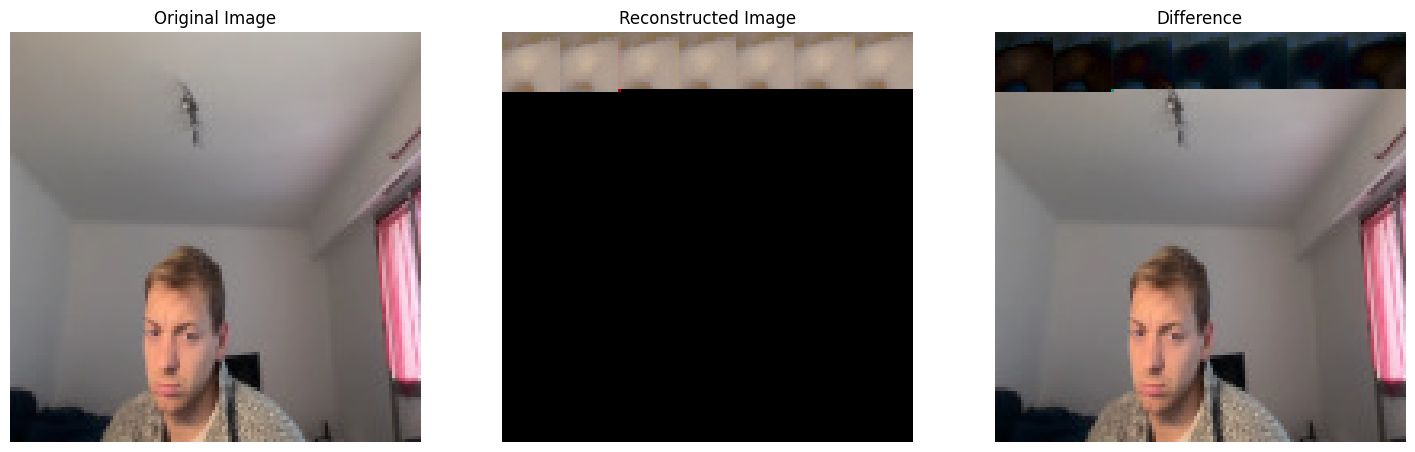

In [5]:
optimal_threshold = 0.07  # This is an example value; adjust it based on your specific use case  
predict_image_status_eim(image_path,reshaped_array,threshold=optimal_threshold)